In [82]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchsummary import summary
from torch.utils.data import random_split

# Load the data

In [83]:
transform = transforms.ToTensor()

train_dataset = datasets.MNIST(root='.', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='.', train=False, download=True, transform=transform)

In [84]:
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: .
    Split: Train
    StandardTransform
Transform: ToTensor()

In [85]:
test_dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: .
    Split: Test
    StandardTransform
Transform: ToTensor()

In [86]:
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 60000
Test dataset size: 10000


In [87]:
# Check shape and label of one item
img, label = train_dataset[0]
print(f"Image shape: {img.shape}")  # Should be [1, 28, 28]
print(f"Image type: {type(img)}")  # Should be [1, 28, 28]
print(f"Label: {label}")

Image shape: torch.Size([1, 28, 28])
Image type: <class 'torch.Tensor'>
Label: 5


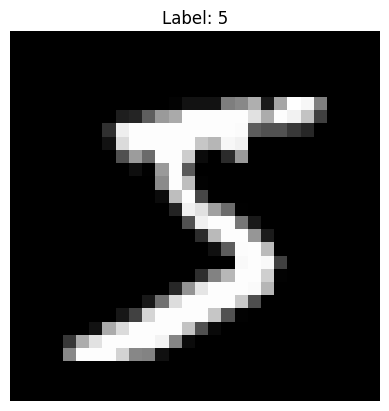

In [88]:
# Remove channel dimension and plot
plt.imshow(img.squeeze(), cmap='gray')
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

In [89]:
def plot_examples(dataset):
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    for i, ax in enumerate(axes.flat):
        img, label = dataset[i]
        ax.imshow(img.squeeze(), cmap='gray')
        ax.set_title(f"Label: {label}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()


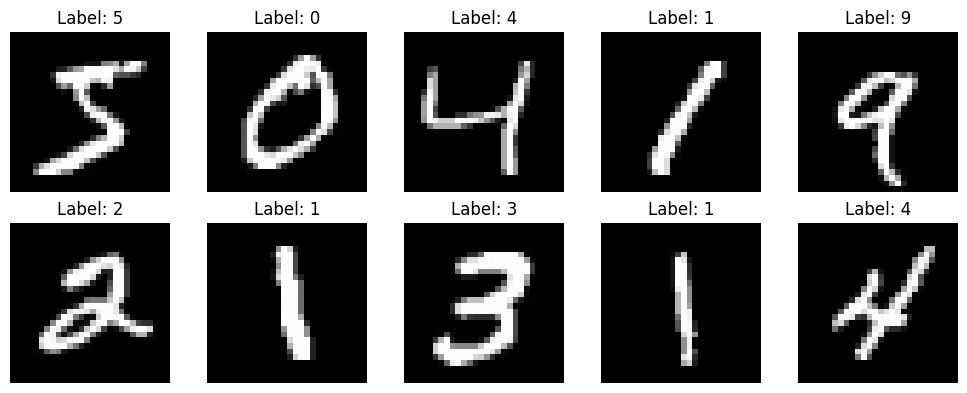

In [90]:
plot_examples(train_dataset)

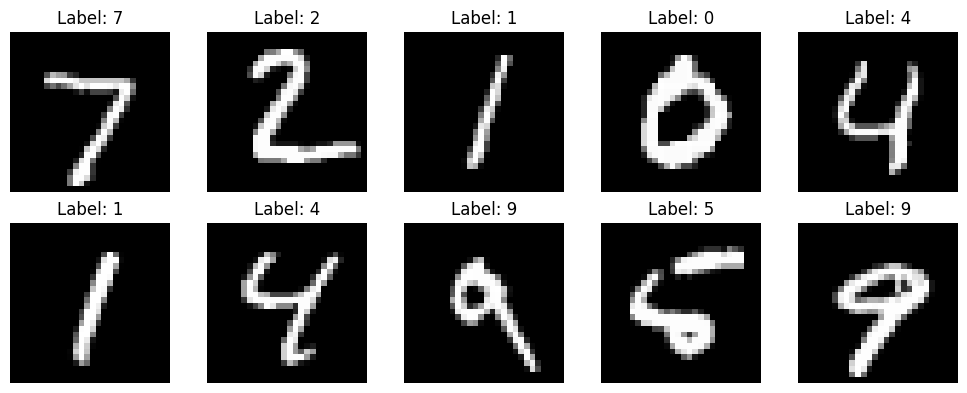

In [91]:
plot_examples(test_dataset)

In [92]:
def get_label(img):
    output = model(img.to(device))
    probs = torch.softmax(output, dim=1)
    label = torch.argmax(probs, dim=1)
    return label.item()

In [93]:
def plot_examples(dataset):
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    for i, ax in enumerate(axes.flat):
        img, label = dataset[i]
        get_label(img)
        ax.imshow(img.squeeze(), cmap='gray')
        ax.set_title(f"True: {label}, Predicted: {get_label(img)}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Model

In [94]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device: {device}')

device: cuda


In [95]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(

            nn.Linear(100, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),

            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),

            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),

            nn.Linear(1024, 784),
            #nn.Sigmoid(),
            nn.Tanh()
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

generator = Generator().to(device)
print(generator)

Generator(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Linear(in_features=256, out_features=512, bias=True)
    (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=512, out_features=1024, bias=True)
    (7): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): Linear(in_features=1024, out_features=784, bias=True)
    (10): Tanh()
  )
)


In [96]:
10*128+128 + 128*256+256 + 256*784+784

235920

In [97]:
summary(generator, input_size=(100,), device=str(device))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]          25,856
       BatchNorm1d-2                  [-1, 256]             512
         LeakyReLU-3                  [-1, 256]               0
            Linear-4                  [-1, 512]         131,584
       BatchNorm1d-5                  [-1, 512]           1,024
         LeakyReLU-6                  [-1, 512]               0
            Linear-7                 [-1, 1024]         525,312
       BatchNorm1d-8                 [-1, 1024]           2,048
         LeakyReLU-9                 [-1, 1024]               0
           Linear-10                  [-1, 784]         803,600
             Tanh-11                  [-1, 784]               0
Total params: 1,489,936
Trainable params: 1,489,936
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forw

In [98]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

discriminator = Discriminator().to(device)
print(discriminator)

Discriminator(
  (linear_relu_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=1024, bias=True)
    (2): ReLU()
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=512, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=1, bias=True)
  )
)


In [99]:
summary(discriminator, input_size=(1, 28, 28), device=str(device))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 1024]         803,840
              ReLU-3                 [-1, 1024]               0
            Linear-4                  [-1, 512]         524,800
              ReLU-5                  [-1, 512]               0
           Dropout-6                  [-1, 512]               0
            Linear-7                  [-1, 128]          65,664
              ReLU-8                  [-1, 128]               0
            Linear-9                    [-1, 1]             129
Total params: 1,394,433
Trainable params: 1,394,433
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 5.32
Estimated Total Size (MB): 5.36
---------------------------------------

Generate some images from the untrained generator

In [100]:
sample_input = torch.randn(10, 100).to(device) # sample from uniform latent space - geenerate 10 sampls
output = (1+generator(sample_input).view(-1, 1, 28, 28))/2

In [101]:
def plot_examples(dataset):
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    for i, ax in enumerate(axes.flat):
        img = dataset[i]
        ax.imshow(img.squeeze(), cmap='gray')
        #ax.set_title(f"True: {label}, Predicted: {get_label(img)}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

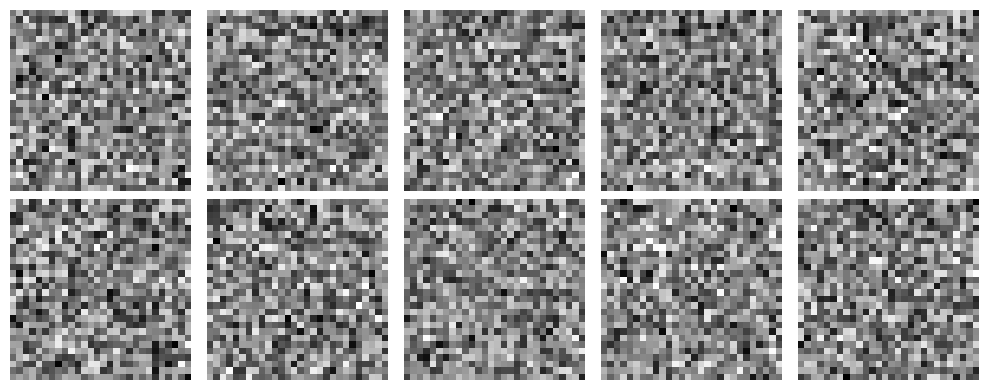

In [102]:
with torch.no_grad():
    generated_images = output.cpu()
plot_examples(generated_images)

Generates noise - as expected!

Ok, for both the real data and noise generator gives 1/2 probability - as expected, becuase its not trained

In order to train the discriminator, we want to minimize the following loss with respect to the discriminator parameters:

$$
L = -\sum_{i=1}^{N_r} \log D(x_i) - \sum_{j=1}^{N_g} \log \left( 1-D(G(z_j)) \right)
$$
The first sum runs over $N_r$ real data samples $x_i$ while the second sum runs over $N_g$ random samples $z_j$ from the latent space.
This result can be obtained from the maximum likelihood principle, i.e. finding the model parameters which maximize the probability of the observed dataset.
The probability that a given sample $x_i$ is real is given by $D(x_i)$. The probability that a given sample $G(z_j)$ is real is given by $D(G(z_j))$, and hence the probability for it to be generated is $1-D(G(z_j))$. Thus, for a set of $N_r$ real and $N_g$ generated samples, the overall probability is
$$
P = \prod_{i=1}^{N_r} D(x_i) \prod_{j=1}^{N_g}  1-D(G(z_j))
$$
The negative log-likelihood is then 
$$
L = -\log P =\sum_i \log D(x_i) - \sum_j \log \left( 1-D(G(z_j))\right)
$$

In order to train the generator, we can _maximize_ the above loss with respect to generator parameters. This follows from the "zero-sum game" or "min-max" idea, i.e. the generator and discriminator compete by maximizing and minimizing the same loss function. Since only the 2nd term depends on G, we maximize the 2nd term only, or minimize the following term:
$$
L = \sum_j \log \left( 1-D(G(z_j)) \right)
$$

Alternatively, we can also start from the maximum likelihood principle, this time for the generator. The goal of the generator is to generate realistic images, so that the discriminator classifies them as real. Thus we want to maximize
$$
P = \prod_{j=1}^{N_g} D(G(z_j)
$$
or in terms of the negative log-likelihood:
$$
L = - \sum_j \log D(G(z_j)
$$



In [103]:
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [104]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1 or classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)

# Apply to both models
generator.apply(weights_init)
discriminator.apply(weights_init)


Discriminator(
  (linear_relu_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=1024, bias=True)
    (2): ReLU()
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=512, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [105]:
# Create a BCEWithLogitsLoss criterion
#criterion = nn.BCEWithLogitsLoss()
criterion = nn.BCELoss()

real_labels = torch.ones(batch_size, 1, device=device)   # labels = 1 for real
fake_labels = torch.zeros(batch_size, 1, device=device)  # labels = 0 for fake

In [106]:
batch_size

64

## Option 1 - BCE Loss (no Sigmoid as a last layer of D, outputs logits)

In [116]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)
#generator_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
#discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4, betas=(0.0, 0.9))
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0.0, 0.9))
lambda_gp = 10

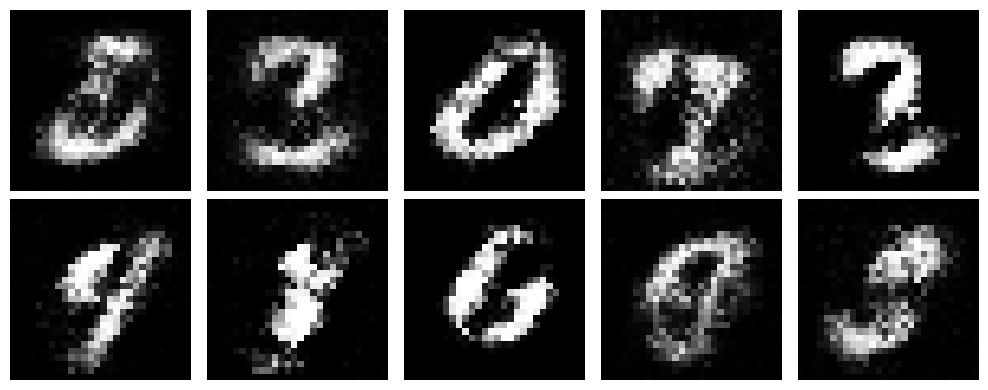

Epoch 0, batch 0 of 937. D-loss: -1.5739864110946655, G-loss: -1.909407615661621
Epoch 1 Finished. Average discriminator Loss: -1.144685, Average generator Loss: -2.2392052882763465. Updated Discriminator 0 times.
Epoch 2 Finished. Average discriminator Loss: -0.913041, Average generator Loss: -1.1022729080949643. Updated Discriminator 0 times.
Epoch 3 Finished. Average discriminator Loss: -0.874507, Average generator Loss: -0.4732317532961363. Updated Discriminator 0 times.
Epoch 4 Finished. Average discriminator Loss: -0.749582, Average generator Loss: -0.5255798736001736. Updated Discriminator 0 times.
Epoch 5 Finished. Average discriminator Loss: -0.646296, Average generator Loss: -0.3838813003448803. Updated Discriminator 0 times.


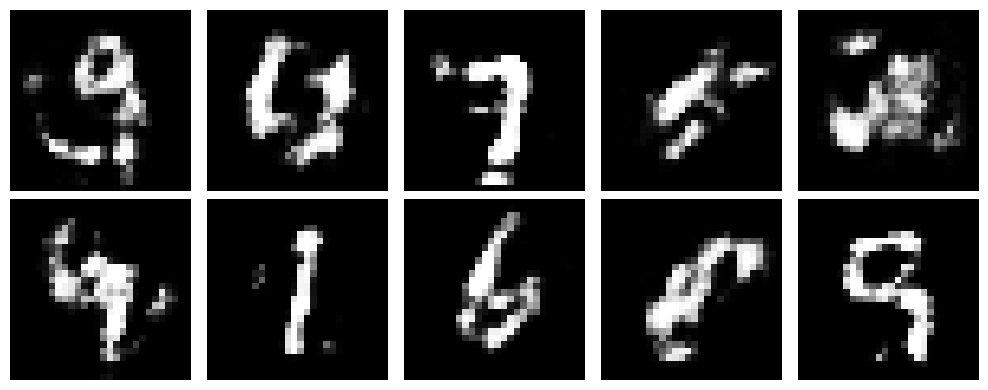

Epoch 6 Finished. Average discriminator Loss: -0.618535, Average generator Loss: -0.15769265627880108. Updated Discriminator 0 times.
Epoch 7 Finished. Average discriminator Loss: -0.588790, Average generator Loss: -0.043436804542808995. Updated Discriminator 0 times.
Epoch 8 Finished. Average discriminator Loss: -0.569214, Average generator Loss: 0.06930567540293966. Updated Discriminator 0 times.
Epoch 9 Finished. Average discriminator Loss: -0.561057, Average generator Loss: 0.19518783459243075. Updated Discriminator 0 times.
Epoch 10 Finished. Average discriminator Loss: -0.537039, Average generator Loss: 0.2252643166150671. Updated Discriminator 0 times.


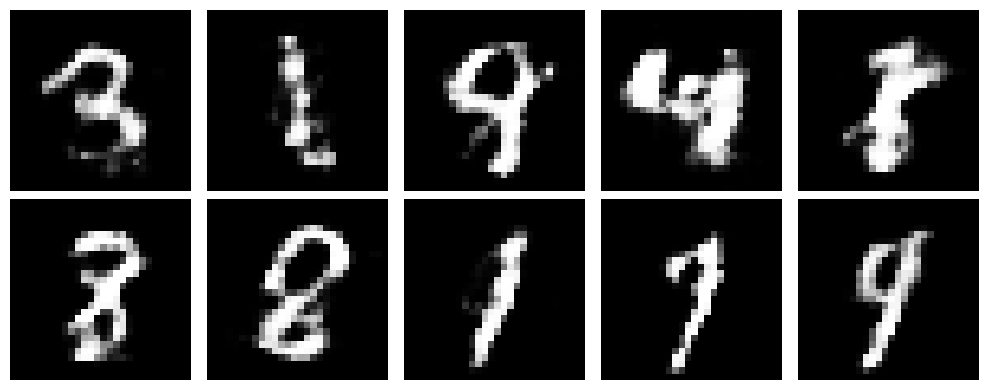

Epoch 11 Finished. Average discriminator Loss: -0.531785, Average generator Loss: 0.281381543826117. Updated Discriminator 0 times.
Epoch 12 Finished. Average discriminator Loss: -0.505824, Average generator Loss: 0.34745784056161233. Updated Discriminator 0 times.
Epoch 13 Finished. Average discriminator Loss: -0.499937, Average generator Loss: 0.37564559933195724. Updated Discriminator 0 times.
Epoch 14 Finished. Average discriminator Loss: -0.478400, Average generator Loss: 0.379408522769451. Updated Discriminator 0 times.
Epoch 15 Finished. Average discriminator Loss: -0.472913, Average generator Loss: 0.4070261127008334. Updated Discriminator 0 times.


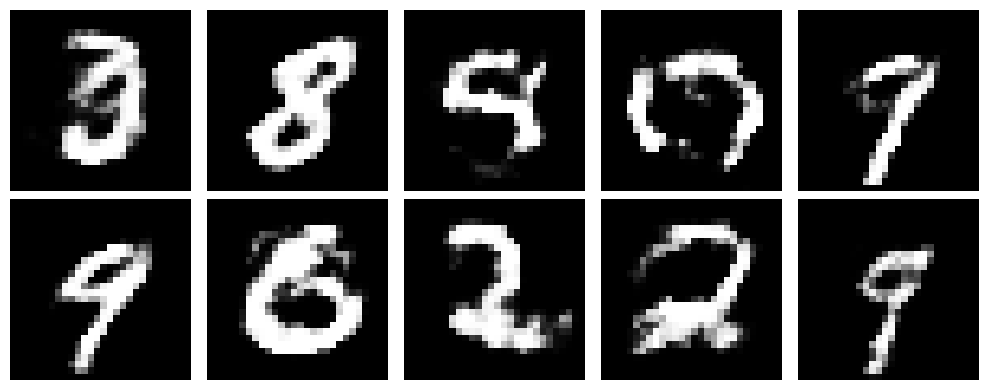

Epoch 16 Finished. Average discriminator Loss: -0.456016, Average generator Loss: 0.4347519636116405. Updated Discriminator 0 times.
Epoch 17 Finished. Average discriminator Loss: -0.450216, Average generator Loss: 0.46534545049856524. Updated Discriminator 0 times.
Epoch 18 Finished. Average discriminator Loss: -0.447259, Average generator Loss: 0.47577857820311187. Updated Discriminator 0 times.
Epoch 19 Finished. Average discriminator Loss: -0.440329, Average generator Loss: 0.5045969769966927. Updated Discriminator 0 times.
Epoch 20 Finished. Average discriminator Loss: -0.430378, Average generator Loss: 0.5117225336962505. Updated Discriminator 0 times.


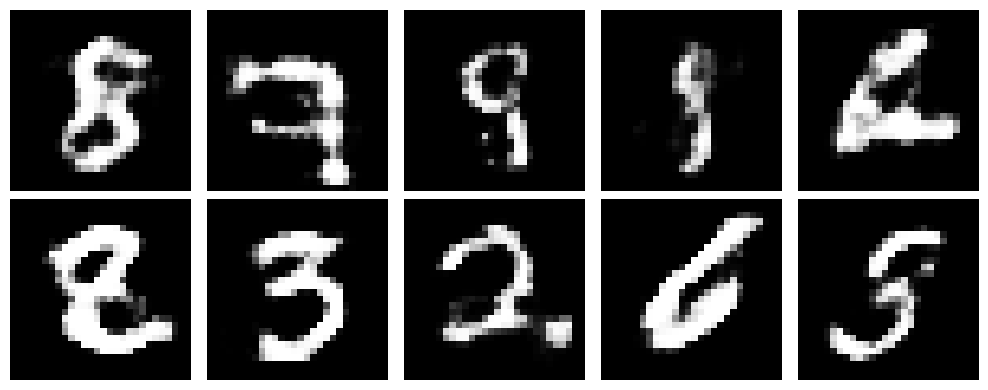

Epoch 21 Finished. Average discriminator Loss: -0.433031, Average generator Loss: 0.5124099436534117. Updated Discriminator 0 times.
Epoch 22 Finished. Average discriminator Loss: -0.414296, Average generator Loss: 0.48457181524970394. Updated Discriminator 0 times.
Epoch 23 Finished. Average discriminator Loss: -0.419711, Average generator Loss: 0.548454262382821. Updated Discriminator 0 times.
Epoch 24 Finished. Average discriminator Loss: -0.407214, Average generator Loss: 0.5617676778838611. Updated Discriminator 0 times.
Epoch 25 Finished. Average discriminator Loss: -0.402213, Average generator Loss: 0.6139521397781442. Updated Discriminator 0 times.


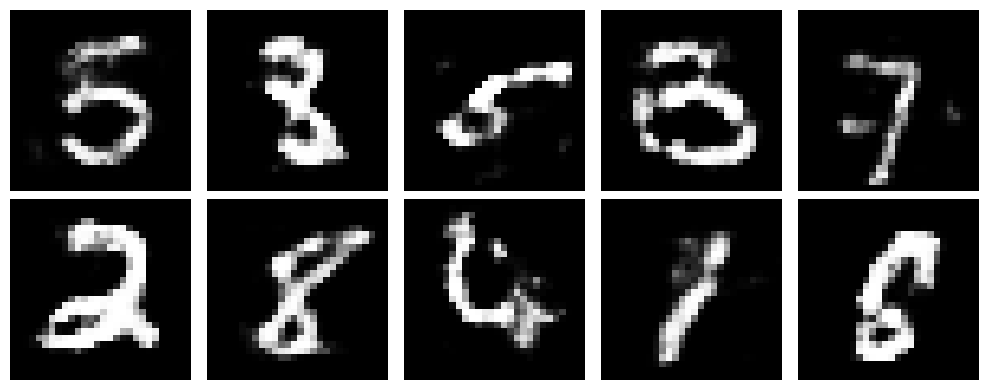

Epoch 26 Finished. Average discriminator Loss: -0.398012, Average generator Loss: 0.6096796719933857. Updated Discriminator 0 times.
Epoch 27 Finished. Average discriminator Loss: -0.379556, Average generator Loss: 0.6109516047897452. Updated Discriminator 0 times.
Epoch 28 Finished. Average discriminator Loss: -0.386129, Average generator Loss: 0.6111930832952627. Updated Discriminator 0 times.
Epoch 29 Finished. Average discriminator Loss: -0.381355, Average generator Loss: 0.592770313536957. Updated Discriminator 0 times.
Epoch 30 Finished. Average discriminator Loss: -0.381582, Average generator Loss: 0.6663782940064273. Updated Discriminator 0 times.


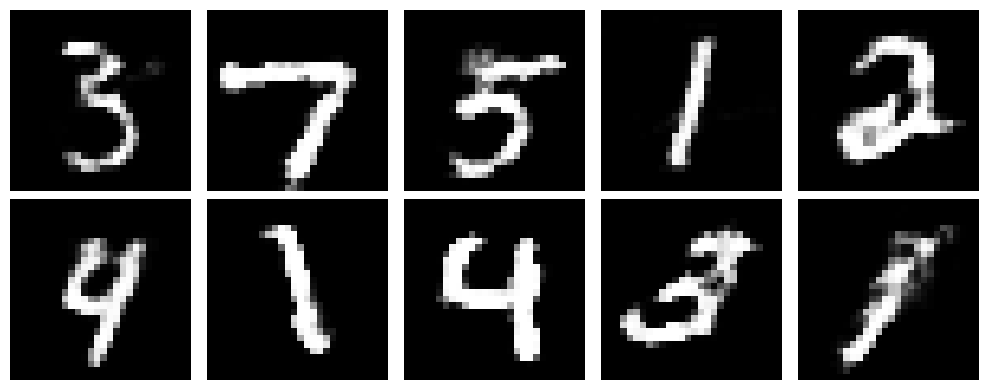

Epoch 31 Finished. Average discriminator Loss: -0.382276, Average generator Loss: 0.6642868399198625. Updated Discriminator 0 times.
Epoch 32 Finished. Average discriminator Loss: -0.372162, Average generator Loss: 0.6611024752187691. Updated Discriminator 0 times.
Epoch 33 Finished. Average discriminator Loss: -0.361859, Average generator Loss: 0.7012608890921641. Updated Discriminator 0 times.
Epoch 34 Finished. Average discriminator Loss: -0.370484, Average generator Loss: 0.7207102801386375. Updated Discriminator 0 times.
Epoch 35 Finished. Average discriminator Loss: -0.366365, Average generator Loss: 0.7035148737160937. Updated Discriminator 0 times.


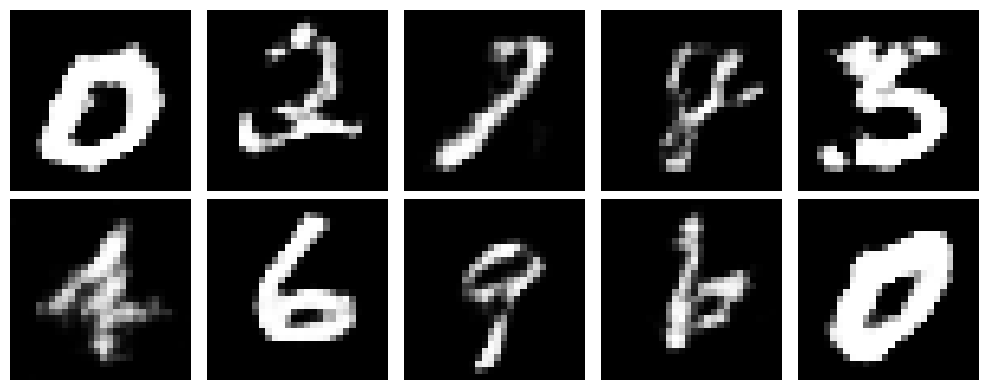

Epoch 36 Finished. Average discriminator Loss: -0.367407, Average generator Loss: 0.7014642259863423. Updated Discriminator 0 times.
Epoch 37 Finished. Average discriminator Loss: -0.347214, Average generator Loss: 0.7539276714260782. Updated Discriminator 0 times.
Epoch 38 Finished. Average discriminator Loss: -0.349322, Average generator Loss: 0.7163086970154844. Updated Discriminator 0 times.
Epoch 39 Finished. Average discriminator Loss: -0.356728, Average generator Loss: 0.7166510531211644. Updated Discriminator 0 times.
Epoch 40 Finished. Average discriminator Loss: -0.347765, Average generator Loss: 0.6841589748181538. Updated Discriminator 0 times.


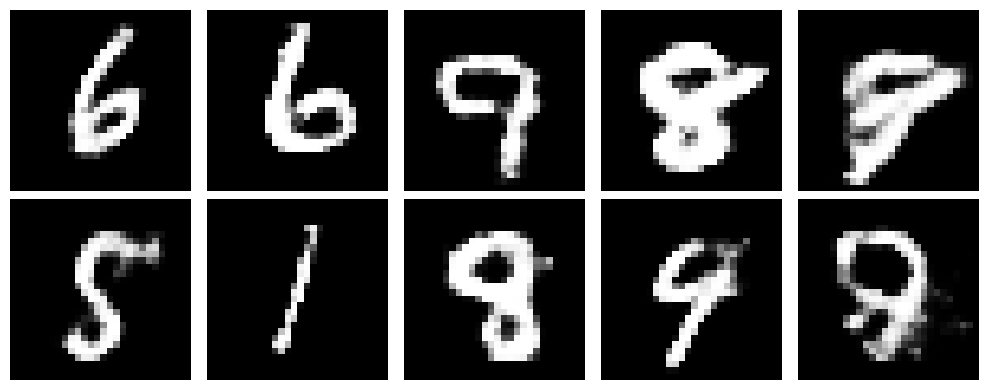

Epoch 41 Finished. Average discriminator Loss: -0.352066, Average generator Loss: 0.7486096283146593. Updated Discriminator 0 times.
Epoch 42 Finished. Average discriminator Loss: -0.357651, Average generator Loss: 0.7280139787452595. Updated Discriminator 0 times.
Epoch 43 Finished. Average discriminator Loss: -0.353033, Average generator Loss: 0.7373885155726013. Updated Discriminator 0 times.
Epoch 44 Finished. Average discriminator Loss: -0.357498, Average generator Loss: 0.7493360303739919. Updated Discriminator 0 times.
Epoch 45 Finished. Average discriminator Loss: -0.355361, Average generator Loss: 0.69494908682509. Updated Discriminator 0 times.


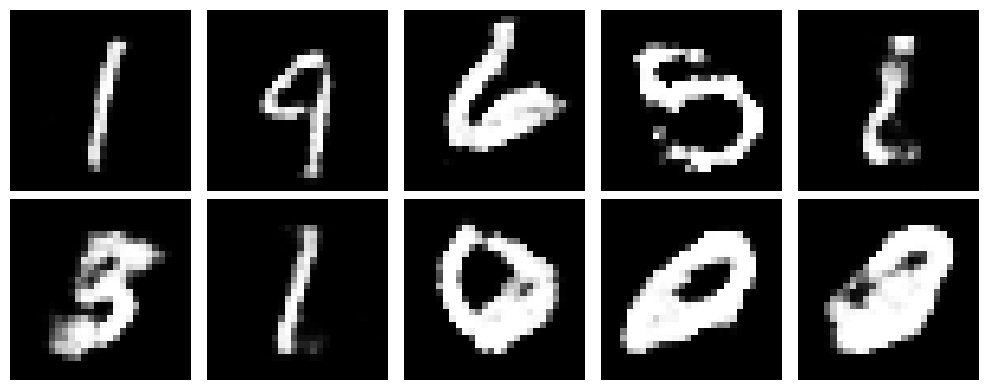

Epoch 46 Finished. Average discriminator Loss: -0.344627, Average generator Loss: 0.6737861788633857. Updated Discriminator 0 times.
Epoch 47 Finished. Average discriminator Loss: -0.344676, Average generator Loss: 0.7220567499104541. Updated Discriminator 0 times.
Epoch 48 Finished. Average discriminator Loss: -0.340452, Average generator Loss: 0.6669249705137364. Updated Discriminator 0 times.
Epoch 49 Finished. Average discriminator Loss: -0.344238, Average generator Loss: 0.7486709901305629. Updated Discriminator 0 times.
Epoch 50 Finished. Average discriminator Loss: -0.329939, Average generator Loss: 0.6765121062273277. Updated Discriminator 0 times.
Training complete.


In [119]:
num_epochs = 50
# we update the discriminator more rarely, otherwise generator struggles to train
discriminator_fraction_update = 200
discriminator_epoch_update = 5 # update ever 10th epoch

batch_print = 200
batch = 0

D_loss = []
G_loss = []
n_D_updates_per_epoch = 1000
for epoch in range(num_epochs):
 
    discriminator_epoch_loss = 0.0
    generator_epoch_loss = 0.0

    # note, no need for labels as we train in an unsupervised fashion!
    i = 0
    batch = 0
    for images, _ in train_loader:    
        
        images = images.to(device)
        bs = images.size(0)
        latent_vectors = torch.randn(batch_size, 100, device=device) 

        ########################################################################
        # Step 1. Train the discriminator, keep the generator fixed.
        ########################################################################
        discriminator.train()
        generator.eval()
        discriminator_optimizer.zero_grad()

        with torch.no_grad():
            G = (1+generator(latent_vectors))/2

        if epoch % 5 == 0 and batch == 0:
            plot_examples(G.view(-1, 1, 28, 28).cpu())
        
        ###
        ###
        # Sample points along straight lines between real and fake
        eps = torch.rand(bs, 1, 1, 1, device=device)
        x_hat = eps * images + (1 - eps) * G.view(-1, 1, 28, 28)
        x_hat.requires_grad_(True)

        D_hat = discriminator(x_hat)
        grad_outputs = torch.ones_like(D_hat)

        gradients = torch.autograd.grad(
            outputs=D_hat,
            inputs=x_hat,
            grad_outputs=grad_outputs,
            create_graph=True,
            retain_graph=True
        )[0]

        grad_norm = gradients.view(bs, -1).norm(2, dim=1)
        gradient_penalty = lambda_gp * ((grad_norm - 1) ** 2).mean()

        # Total discriminator loss
        loss_D = torch.mean(discriminator(G)) - torch.mean(discriminator(images)) + gradient_penalty

        loss_D.backward()
        discriminator_epoch_loss += loss_D.item()
        discriminator_optimizer.step()
        #for p in discriminator.parameters():
        #    p.data.clamp_(-0.01, 0.01)

        ########################################################################
        # Step 2. Train the generator, keep the discriminator fixed.
        ########################################################################
        discriminator.eval()
        generator.train()      
        generator_optimizer.zero_grad()
        
        G = (1+generator(latent_vectors))/2
        
        # Generator tries to fool discriminator, so uses real labels for fake outputs
        loss_G = -torch.mean(discriminator(G))
        loss_G.backward()

        generator_optimizer.step()
        generator_epoch_loss += loss_G.item()

        if batch  == 0 and epoch==0:
            print(f'Epoch {epoch}, batch {batch} of {len(train_loader)}. D-loss: {loss_D}, G-loss: {loss_G}')
        batch += 1

    discriminator_epoch_loss /= len(train_loader)
    generator_epoch_loss /= len(train_loader)

    D_loss.append(discriminator_epoch_loss)
    G_loss.append(generator_epoch_loss)

    print(f"Epoch {epoch+1} Finished. Average discriminator Loss: {discriminator_epoch_loss:4f}, Average generator Loss: {generator_epoch_loss}. Updated Discriminator {i} times.")

print("Training complete.")

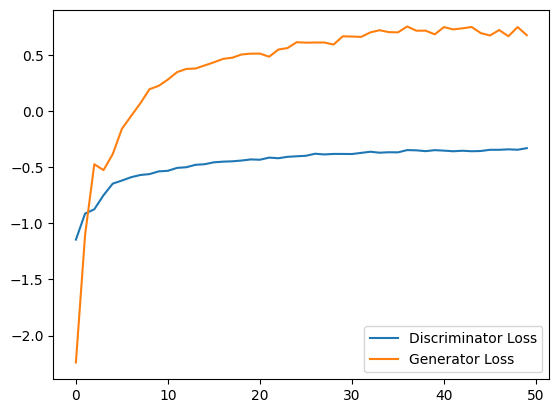

In [120]:
plt.plot(D_loss, label='Discriminator Loss')
plt.plot(G_loss, label='Generator Loss')
plt.legend()

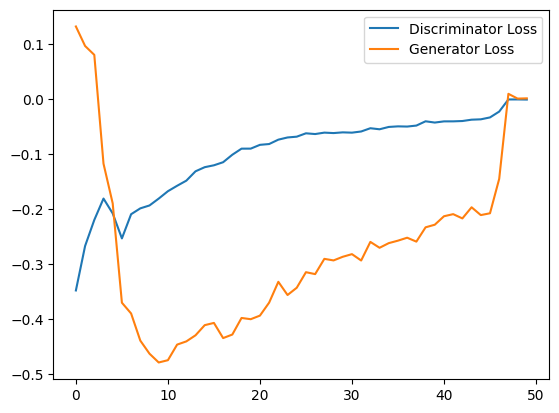

In [110]:
plt.plot(D_loss, label='Discriminator Loss')
plt.plot(G_loss, label='Generator Loss')
plt.legend()

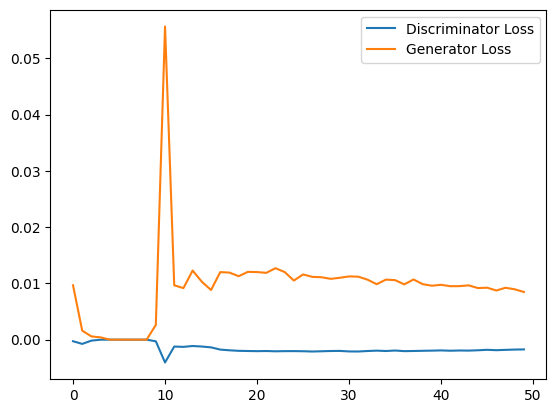

In [113]:
plt.plot(D_loss, label='Discriminator Loss')
plt.plot(G_loss, label='Generator Loss')
plt.legend()